# Appeltant DFR Implementation

This Google Colab project provides an visual demonstration of the delayed feedback reservoir system conceptualized by Lennert Appeltant. Here we test the DFR's ability to predict future values in a time series where the output at any given time is a function of the previous 10 inputs and outputs.

Relevant Papers:
"Information processing using a single dynamical node as complex system"

https://www.nature.com/articles/ncomms1476

"Reservoir computing based on delay-dynamical systems"

https://core.ac.uk/download/pdf/33010007.pdf


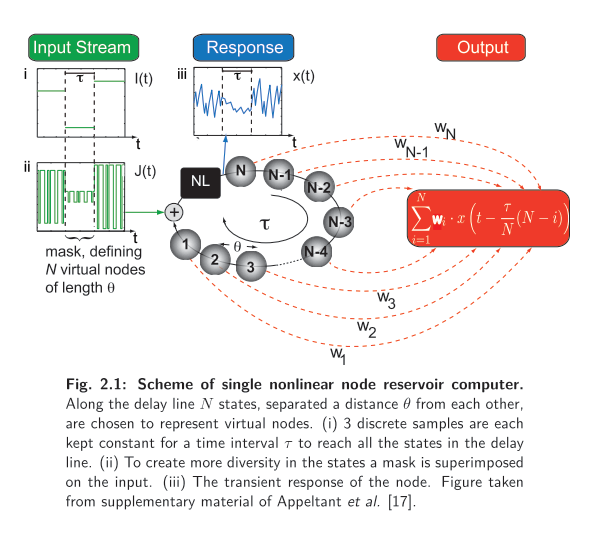

## Import Statements

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.core.function_base import linspace
import sys

# configure random number generator seed
rng = np.random.default_rng(0)

## NARMA 10 Dataset Generation

Here we generate the input and output data according to the equation from the papers.

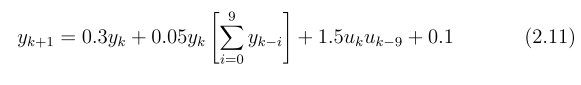

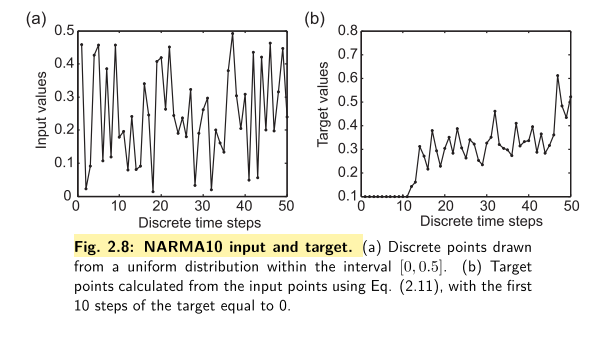

In [17]:
def narma10_create(inLen):

    # Compute the random uniform input matrix
    inp = 0.5*rng.random(inLen)

    # Compute the target matrix
    tar = np.zeros(inLen)

    for k in range(9,(inLen - 1)):
        tar[k+1] = 0.3 * tar[k] + 0.05 * tar[k] * np.sum(tar[k-9:k]) + 1.5 * inp[k] * inp[k - 9] + 0.1
    
    
    return (inp, tar)

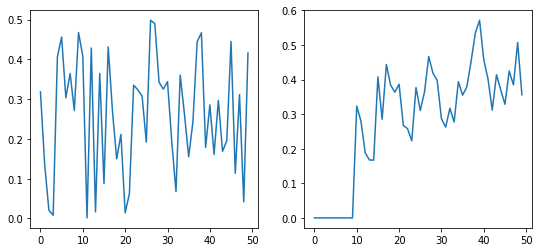

In [18]:
# display data sets

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
inp_vals, targ_vals = narma10_create(50)
axes[0].plot(inp_vals)
axes[1].plot(targ_vals);

## Mackey-Glass Transfer Function

Here we recreate the transfer (activation) function for the single non-linear node in the delayed feedback reservoir.

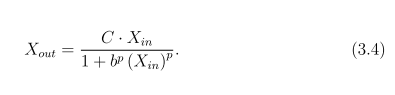

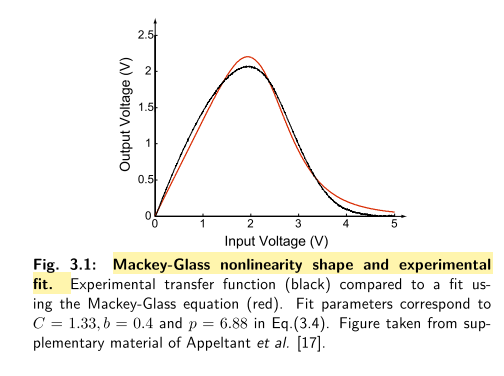

In [19]:
def mg(x):

    C = 1.33

    # here we choose to set p = 1 instead of 6.88 as in Figure 3.1
    # since our NARMA10 data set works best with p = 1
    p = 6.88 

    b = 0.4

    return C * x / (1 + np.power(b * x,p))
    # a = 2
    # b = 0.8
    # c = 0.2
    # d = 2.1
    # p = 10

    # return (a * x) / (b + c * np.power( (d * x), p) )

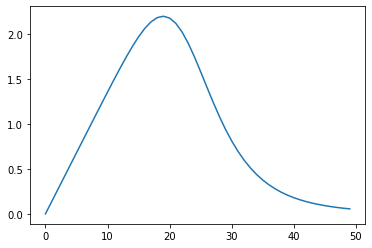

In [20]:
inp_V = np.linspace(0, 5, 50)
out_V = mg(inp_V)
plt.plot(out_V)
plt.show()

## DFR Parameters

Here we configure the parameters/attributes of the delayed feedback reservoir.

In [21]:
num_samples = 6000 # total samples
init_samples = 200 # initialization samples initial 200
m = 4000 # training samples initial 4000

gamma = 0.05 # input gain
eta = 0.5 # feedback scale

tau = 80 # delay
N = 400 # number of virtual nodes
theta = tau / N # node separation: more delay = higher separation; more nodes = lower separation

## DFR Data & Mask

Here we "mask" the input data before feeding it into the DFR.

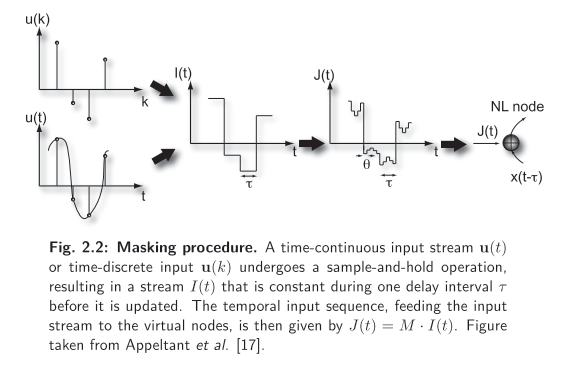

In [22]:
#narma10 input & output data
u, y = narma10_create(num_samples)
y_train = y[init_samples:init_samples+m]

# weight generation
W = rng.random(N)

# mask values: [-0.1,0.1]
M = rng.choice([-0.1,0.1],N)

# mask generation
J = np.empty((num_samples,N))
for i in range(num_samples):
    J[i] = M * u[i]

## Reservoir Initialization

Before we start evaluating the DFR, we initialize it with `m` input samples.

In [23]:
# reservoir initialization
X = np.zeros(N)
X_history = np.zeros((m,N))
for i in range(init_samples):
    for j in range(N):
        g_i = mg(gamma * J[i][j] + eta * X[N - 1])
        X[1:N] = X[0:N - 1]
        X[0] = g_i
    X_history[i] = X

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()


## Reservoir Evaluation

Now we start recording the output of the reservoir for each of the `m` input samples.

In [24]:
# dfr stage
for i in range(m):
    for j in range(N):
        g_i = mg(gamma * J[init_samples + i][j] + eta * X[N - 1])
        X[1:N] = X[0:N - 1]
        X[0] = g_i
    X_history[i] = X

# Weight Training (Gradient Descent)

In [25]:
# # number of gradient descent iterations
# iterations = 10

# # gradient descent learning rate
# learning_rate = 50

# randomized initial weights
#W = np.multiply(np.random.random(N),np.sqrt(2/N)) # He initialization: we just simply multiply random initialization with
# from sklearn.linear_model import SGDRegressor
# clf = SGDRegressor(max_iter=100, tol=1e-3) #default learning rate is 0.01 ^0.25
# clf.fit(X_history, y_train)
# #y_pred = clf.predict(X_test)
# W = clf.coef_
# print(len(W))
#print(W)
# gradient descent iterations
# for i in range(iterations):

#     # calculate predicted outputs
#     y_hat_reg = X_history.dot(W)
#     # calculate weight updates
#     for weight_index in range(W.size):

#         W[weight_index] = W[weight_index] - learning_rate * np.mean( (y_hat_reg - y_train) * X_history[:,weight_index])

#     # display new NRMSE value
#     nrmse = (np.linalg.norm(y_hat_reg - y_train) / np.linalg.norm(y_train))
#     print(f"NRMSE: {nrmse}")

In [26]:
# import numpy as np
# import tensorflow as tf
# opt = tf.keras.optimizers.SGD(learning_rate=0.1)
# loss = (np.linalg.norm(y_hat_reg - y_train) / np.linalg.norm(y_train))

## NRMSE Error Determination

Now we evaluate the model's performance against the training data.

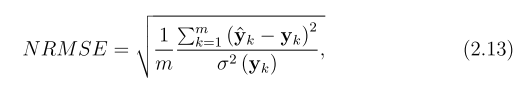

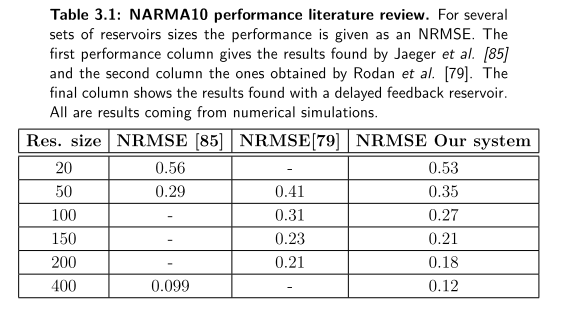

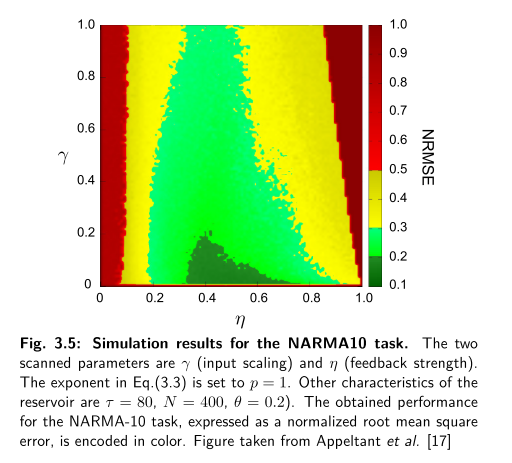

In [12]:
# calculate predicted outputs
y_hat_reg = X_history.dot(W)
# calculate error
# we use the normalized root mean squared error that other MICS students have used
nrmse = (np.linalg.norm(y_hat_reg - y_train) / np.linalg.norm(y_train))
print(f"NRMSE: {nrmse}")

NRMSE: 0.9835379079365405


## Plot Data

The plot below helps us to visualize how well the DFR model's the expected output data after the output weights have been trained using ridge regression.

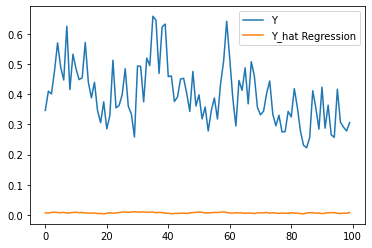

In [13]:
plt_samples =100
plt.plot(y_train[:plt_samples],label="Y")
plt.plot(y_hat_reg[:plt_samples],label="Y_hat Regression")
plt.legend()
plt.show()